In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

def prepare_data_gray(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    
    labels = np.array(labels)
    
    return images, labels

def prepare_data_as_paper(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES - 1, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [ ]:
def weighted_cross_entropy(y_true, y_pred):
    p = tf.reduce_sum(y_true)
    n = tf.cast(tf.size(y_true), tf.float32) - p
    beta_p = (p + n) / (p + 1e-7)
    beta_n = (p + n) / (n + 1e-7)
    loss = -beta_p * y_true * tf.math.log(y_pred + 1e-7) - beta_n * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) # Add epsilon to avoid log(0)
    return tf.reduce_mean(loss)

In [ ]:
def weighted_cross_entropy2(y_true, y_pred):
    tf.print("y_true", y_true, summarize=-1)
    tf.print("y_pred", y_pred, summarize=-1)

    positive_cases = tf.equal(y_true[:, -1], 0)  # Positive when last column is 0
    negative_cases = tf.equal(y_true[:, -1], 1)  # Negative when last column is 1
    positive_cases = tf.cast(positive_cases, tf.float32)
    negative_cases = tf.cast(negative_cases, tf.float32)
    
    tf.print("positive_cases", positive_cases, summarize=-1)
    tf.print("negative_cases", negative_cases, summarize=-1)
    
    count_positive = tf.reduce_sum(positive_cases)
    count_negative = tf.reduce_sum(negative_cases)
    
    tf.print("count_positive", count_positive, summarize=-1)
    tf.print("count_negative", count_negative, summarize=-1)
    
    total_samples = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    tf.print("total_samples", total_samples)

    beta_p = total_samples / count_positive
    beta_n = total_samples / count_negative
    
    beta_p = tf.clip_by_value(beta_p, 1e-7, 1e7) #  Clipping 
    beta_n = tf.clip_by_value(beta_n, 1e-7, 1e7)
    
    tf.print("beta_p", beta_p, summarize=-1)
    tf.print("beta_n", beta_n, summarize=-1)
    
    y_pred_binary = tf.stack([tf.reduce_sum(y_pred[:, :-1], axis=-1), y_pred[:, -1]], axis=-1)

    
    y_pred_binary = tf.cast(y_pred_binary, tf.float32)

    tf.print("y_pred_binary", y_pred_binary, summarize=-1)
    
    weighted_positive_loss = beta_p * tf.reduce_sum(-positive_cases * tf.math.log(y_pred_binary[:, 0] + 1e-7))
    weighted_negative_loss = beta_n * tf.reduce_sum(-negative_cases * tf.math.log(y_pred_binary[:, 1] + 1e-7))
    
    tf.print("weighted_positive_loss", weighted_positive_loss, summarize=-1)
    tf.print("weighted_negative_loss", weighted_negative_loss, summarize=-1)   
    
    return weighted_positive_loss + weighted_negative_loss

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [3]:
def create_model_1(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_2(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        # BatchNormalization(), # new
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'), # new
        Conv2D(128, (3, 3), activation='relu'), # new
        # BatchNormalization(),
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(256, activation='relu'), # former 128
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_3(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu'), # new
        Conv2D(256, (3, 3), activation='relu'), # new
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(512, activation='relu'), # former 256
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

In [4]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    images_test = tf.cast(images_test, np.float32) / 255.0
    
    predictions = model.predict(images_test, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [ ]:
NUMBER_OF_IMAGES = 10000
IMAGE_SIZE = 256
BATCH_SIZE = 16

images, labels = prepare_data_gray(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
images_test, labels_test = prepare_data_gray(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)

train_dataset = create_train_dataset(images_train, labels_train)

val_dataset = create_val_dataset(images_val, labels_val)

In [ ]:
model = create_model_1(IMAGE_SIZE)

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

# class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
# class_weights = {i: class_weights[i] for i in range(len(class_weights))}

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

In [ ]:
plt.figure(figsize=(8, 6))

font_size = 16

plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")

plt.xlabel("Epochs", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="upper right")

plt.savefig("evals/own_models/image_test_fix/histories/history_256px_10000samples_model1.pdf", bbox_inches='tight', pad_inches=0)

plt.show()


In [ ]:
# Resolution

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 1000
evaluations = {}

for ev_image_size in [32, 112, 224, 336, 448]:
    
    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
    
    train_dataset = create_train_dataset(images_train,labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
    
    model = create_resnet_model(ev_image_size)
    
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE

    model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    evals = evaluate_model(model, images_test, labels_test)
    
    evaluations[ev_image_size] = evals
    print(f'\n{evals}\n')
    
print(evaluations)

In [ ]:
with open("pickles/resolution_1000samples.pkl", "wb") as file:
    pickle.dump(evaluations, file)

All labels: 10000 samples, 50 epochs: 
[0.6692994173103355, 0.5939930395255514, 0.6683094818155433, 0.5533819389301956, 0.6756526600600586, 0.5141695372704997, 0.5874413145539906, 0.814388249040227, 0.6113292270077111, 0.5362483786464559, 0.5052575717787114, 0.39618781165543754, 0.4708606350806452, 0.5637999231950844]

In [8]:
# Resolution for multiple runs

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

# for ev_image_size in [100, 200, 224, 300, 400, 500, 768, 1024]:
# for ev_image_size in [32, 64, 128, 192, 256, 320, 384]:
for ev_image_size in [224]:
    
    evals_per_size = []

    for i in range(5):     
        
        tf.keras.backend.clear_session()
        
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data_gray(df[:NUMBER_OF_IMAGES], ev_image_size)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
        images_test, labels_test = prepare_data_gray(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        # model = create_resnet_model(ev_image_size) #MAKE PREPARE DATA NORMAL
        # model = create_model_1(ev_image_size)
        # model = create_model_2(ev_image_size)
        model = create_model_3(ev_image_size) #HERE

        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                
        history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=1)
        
        evals = evaluate_model(model, images_test, labels_test)
        evals_per_size.append(evals)
        print(evals_per_size)
        with open(f"pickles/resOnly224/history_model3_{i}.pkl", "wb") as file:
            pickle.dump(history, file)
        
    evaluations[ev_image_size] = evals_per_size
    print(f'\n{evals_per_size}\n')
    
with open(f"pickles/resOnly224/resonly224_model3.pkl", "wb") as file:
    pickle.dump(evaluations[224], file)
    
print(evaluations)

100%|██████████| 2000/2000 [00:23<00:00, 83.93it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 348ms/step - auc: 0.8220 - loss: 1.0698 - val_auc: 0.8096 - val_loss: 0.9702
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 354ms/step - auc: 0.8226 - loss: 0.9290 - val_auc: 0.8127 - val_loss: 0.9614
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 181s 361ms/step - auc: 0.8243 - loss: 0.9253 - val_auc: 0.8127 - val_loss: 0.9614
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 172s 343ms/step - auc: 0.8251 - loss: 0.9255 - val_auc: 0.8127 - val_loss: 0.9599
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 166s 331ms/step - auc: 0.8268 - loss: 0.9223 - val_auc: 0.8127 - val_loss: 0.9576
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 330ms/step - auc: 0.8260 - loss: 0.9208 - val_auc: 0.8127 - val_loss: 0.9575
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 164s 329ms/step - auc: 0.8253 - loss: 0.9245 - val_auc: 0.8127 - val_loss: 0.9594
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 329ms/step - auc: 0.8237 - loss: 0.9238 - val_auc: 0.8127 - val_loss: 0.9577
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:27<00:00, 73.84it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 337ms/step - auc: 0.8129 - loss: 1.4349 - val_auc: 0.8203 - val_loss: 0.9510
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - auc: 0.8216 - loss: 0.9481 - val_auc: 0.8203 - val_loss: 0.9521
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 335ms/step - auc: 0.8170 - loss: 0.9530 - val_auc: 0.8203 - val_loss: 0.9494
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 335ms/step - auc: 0.8159 - loss: 0.9523 - val_auc: 0.8203 - val_loss: 0.9489
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - auc: 0.8197 - loss: 0.9496 - val_auc: 0.8203 - val_loss: 0.9481
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - auc: 0.8165 - loss: 0.9524 - val_auc: 0.8203 - val_loss: 0.9483
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 337ms/step - auc: 0.8203 - loss: 0.9444 - val_auc: 0.8203 - val_loss: 0.9464
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - auc: 0.8186 - loss: 0.9455 - val_auc: 0.8203 - val_loss: 0.9457
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:28<00:00, 69.03it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 179s 354ms/step - auc: 0.8163 - loss: 1.4227 - val_auc: 0.8167 - val_loss: 0.9647
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 353ms/step - auc: 0.8132 - loss: 0.9644 - val_auc: 0.8167 - val_loss: 0.9552
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 352ms/step - auc: 0.8187 - loss: 0.9540 - val_auc: 0.8167 - val_loss: 0.9627
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 353ms/step - auc: 0.8192 - loss: 0.9538 - val_auc: 0.8167 - val_loss: 0.9549
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 352ms/step - auc: 0.8206 - loss: 0.9510 - val_auc: 0.8167 - val_loss: 0.9545
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 352ms/step - auc: 0.8203 - loss: 0.9506 - val_auc: 0.8167 - val_loss: 0.9523
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 352ms/step - auc: 0.8161 - loss: 0.9554 - val_auc: 0.8167 - val_loss: 0.9540
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 352ms/step - auc: 0.8180 - loss: 0.9515 - val_auc: 0.8167 - val_loss: 0.9518
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 74.56it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 361ms/step - auc: 0.8063 - loss: 1.4115 - val_auc: 0.8232 - val_loss: 0.9397
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 360ms/step - auc: 0.8135 - loss: 0.9708 - val_auc: 0.8232 - val_loss: 0.9399
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 181s 361ms/step - auc: 0.8121 - loss: 0.9705 - val_auc: 0.8232 - val_loss: 0.9369
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 360ms/step - auc: 0.8150 - loss: 0.9658 - val_auc: 0.8232 - val_loss: 0.9383
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 360ms/step - auc: 0.8124 - loss: 0.9649 - val_auc: 0.8232 - val_loss: 0.9434
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 360ms/step - auc: 0.8137 - loss: 0.9643 - val_auc: 0.8232 - val_loss: 0.9413
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 359ms/step - auc: 0.8132 - loss: 0.9644 - val_auc: 0.8232 - val_loss: 0.9370
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 360ms/step - auc: 0.8118 - loss: 0.9681 - val_auc: 0.8232 - val_loss: 0.9455
125/125 ━━━━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:29<00:00, 67.32it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 180s 356ms/step - auc: 0.8149 - loss: 1.0907 - val_auc: 0.8135 - val_loss: 0.9802
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 354ms/step - auc: 0.8144 - loss: 0.9668 - val_auc: 0.8135 - val_loss: 0.9787
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 354ms/step - auc: 0.8150 - loss: 0.9615 - val_auc: 0.8135 - val_loss: 0.9762
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 353ms/step - auc: 0.8147 - loss: 0.9568 - val_auc: 0.8135 - val_loss: 0.9788
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 353ms/step - auc: 0.8133 - loss: 0.9592 - val_auc: 0.8135 - val_loss: 0.9763
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 353ms/step - auc: 0.8148 - loss: 0.9588 - val_auc: 0.8135 - val_loss: 0.9754
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 353ms/step - auc: 0.8150 - loss: 0.9566 - val_auc: 0.8135 - val_loss: 0.9765
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 355ms/step - auc: 0.8167 - loss: 0.9572 - val_auc: 0.8135 - val_loss: 0.9757
Epoch 9/20
500/500 ━━━━━

In [9]:
# Resolution for multiple runs #######adaspdkjsaioödjaoisdsaiodloiösdiöa

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

# for ev_image_size in [100, 200, 224, 300, 400, 500, 768, 1024]:
# for ev_image_size in [32, 64, 128, 192, 256, 320, 384]:
for ev_image_size in [32, 112, 224, 336, 448]:
    
    evals_per_size = []

    for i in range(5):     
        
        tf.keras.backend.clear_session()
        
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        model = create_resnet_model(ev_image_size) #MAKE PREPARE DATA NORMAL
        # model = create_model_1(ev_image_size)
        # model = create_model_2(ev_image_size)
        # model = create_model_3(ev_image_size) 

        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                
        history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=1)
        
        evals = evaluate_model(model, images_test, labels_test)
        evals_per_size.append(evals)
        print(evals_per_size)
        
    evaluations[ev_image_size] = evals_per_size
    print(f'\n{evals_per_size}\n')
    
with open(f"pickles/chest8xray/50epochs_resolution_10000samples_5runs.pkl", "wb") as file:
    pickle.dump(evaluations[224], file)
    
print(evaluations)

100%|██████████| 2000/2000 [00:26<00:00, 76.34it/s]


NameError: name 'create_resnet_model' is not defined

In [3]:
# 10000 images, resnet, 50 epochs but early stopping after patience 5
evaluations = {}
evaluations[32] = [([0.5888133640552995, 0.6725112723686064, 0.6094750861079219, 0.6518609217238466], 0.25, 0.6735), ([0.6530570387674509, 0.7324490489130434, 0.5816865668423058, 0.6394575498575498], 0.25, 0.675), ([0.5821659204090379, 0.7152173989971372, 0.6115952368971541, 0.6584638355458327], 0.25, 0.6835), ([0.690067159820907, 0.6859495800656321, 0.617864705882353, 0.664456504981596], 0.25, 0.706), ([0.6327688446881681, 0.7430597571442641, 0.5890247459396396, 0.6520623829904997], 0.25, 0.6965)]
evaluations[112] = [([0.6335599078341013, 0.6953085282917517, 0.6658444981164174, 0.6824242805736527], 0.25463569368368133, 0.6875), ([0.629870402374494, 0.7190742526518805, 0.6372807120180344, 0.6708753268229458], 0.2589399549885702, 0.695), ([0.6523367707707117, 0.7213458478767623, 0.6317967917795119, 0.6766343707637741], 0.2535361593315201, 0.6825), ([0.5904766183631645, 0.6342625549322779, 0.5934381812041387, 0.6280214418221406], 0.25, 0.681), ([0.5945511605694447, 0.6477831173523384, 0.6112256534146616, 0.6433514553518187], 0.25, 0.688)]
evaluations[224] = [([0.6198310291858679, 0.6551711990982104, 0.5960707233065443, 0.6414924663849448], 0.25100850893723947, 0.6715), ([0.6120786751209744, 0.6635597826086956, 0.5942466807082115, 0.6328284900284901], 0.25074850299401197, 0.6755), ([0.5994554535916419, 0.7131189599102591, 0.6132638684216202, 0.6579426356535396], 0.2507824511912532, 0.681), ([0.6491791577444683, 0.6603919850937205, 0.6151980392156864, 0.6546800023125398], 0.250604343720491, 0.704), ([0.6094432568082536, 0.646853146853147, 0.6123890884529183, 0.6289750706935477], 0.24964106245513282, 0.6955)]

# patience 5: [([0.5489227727704354, 0.6651389553111218, 0.6211693021906282, 0.6359226114096015], 0.25028126581384674, 0.6955), ([0.5672628726287262, 0.6785496250444207, 0.5604398316927938, 0.6151374963474323], 0.2496301775147929, 0.675), ([0.6031925867645773, 0.691069405507853, 0.6109329489537253, 0.6607429162147114], 0.25181191269143627, 0.684), ([0.6224764441458304, 0.6595795157992249, 0.5846321840863953, 0.6345405785024727], 0.250293827194837, 0.7085), ([0.6114859230734244, 0.6694684153565733, 0.5973915040183697, 0.6387296321295589], 0.25058820252882524, 0.6905)]
# patience 10: [([0.6402112135176651, 0.68713079955012, 0.5983285876334005, 0.6492145358470394], 0.2500991183743179, 0.695), ([0.6150817384370015, 0.643822965187451, 0.6423649942666928, 0.6615511968489923], 0.25323987601340014, 0.6905), ([0.6288448393711552, 0.659561400929728, 0.5998196890735976, 0.6281890214250979], 0.2506112331061961, 0.676), ([0.619462775350869, 0.6684176762088938, 0.590870756302841, 0.6345233101162473], 0.25051042369871357, 0.6815)]

evaluations[336] = [([0.6106797235023042, 0.6217982536074103, 0.5974355176813707, 0.6242319649457786], 0.2520407379476007, 0.689), ([0.5706110583360993, 0.6196689167470266, 0.5888579474098862, 0.6049532421189066], 0.25, 0.6935), ([0.5928045032811902, 0.6177308550919474, 0.5976764493576359, 0.6296552060314572], 0.25, 0.686), ([0.5532173726719452, 0.6280898911953325, 0.5862385250683123, 0.6191372175346047], 0.25, 0.681)]

# patience 5: [([0.5878850219249177, 0.5969117117117116, 0.5960896755944489, 0.6112060039321333], 0.25, 0.6815), ([0.5965865973965326, 0.6057070886977762, 0.6043615467947812, 0.5962643131147067], 0.24981684981684982, 0.682)]


evaluations[448] = [([0.5222917542302963, 0.6005499760879962, 0.6070873833357513, 0.5995599319260458], 0.2507420004001271, 0.695)]

In [ ]:
# model 1, 20 epochs, early stopping, 1000 images

evaluations = {32: [([0.49837837837837834, 0.6310160427807486, 0.59789972899729, 0.6024816176470588], 0.25, 0.68), ([0.5879755434782609, 0.5150143973673386, 0.6108803986710963, 0.5567415041099252], 0.25, 0.715), ([0.5649898226228554, 0.46466973886328716, 0.6424521615875266, 0.5787229267197845], 0.25, 0.665), ([0.6041666666666667, 0.6009872480460716, 0.6936882435974995, 0.6911466260781329], 0.25, 0.73), ([0.4570446735395189, 0.6416184971098265, 0.5536853295535081, 0.6118280776568287], 0.25, 0.665)], 64: [([0.6170300287947347, 0.42388888888888887, 0.5588822355289421, 0.5385006784260516], 0.25, 0.67), ([0.5129076086956521, 0.6196571428571429, 0.5270588235294118, 0.5791025221094007], 0.25, 0.645), ([0.683963963963964, 0.452972972972973, 0.4964700996677741, 0.5501457017969889], 0.25, 0.71), ([0.47063063063063065, 0.48847517730496454, 0.5647656940760389, 0.5306122448979592], 0.25, 0.735), ([0.5421195652173914, 0.571388888888889, 0.5744873888586464, 0.577718774200686], 0.25, 0.655)], 128: [([0.5926315789473684, 0.6177174780526735, 0.5161233167965982, 0.582108262108262], 0.25, 0.675), ([0.5828970331588132, 0.4113451086956522, 0.5687665136976776, 0.5505642361111112], 0.25, 0.64), ([0.6414655423088107, 0.38378378378378375, 0.4413852813852813, 0.5694213961721429], 0.25, 0.655), ([0.3983516483516484, 0.5326617826617827, 0.5466755098656939, 0.5035055549563154], 0.25, 0.635), ([0.5391102064553649, 0.656291566906092, 0.5567047722736346, 0.6129867328227808], 0.25, 0.635)], 192: [([0.4524456521739131, 0.6505555555555556, 0.6244419642857144, 0.5994875222816399], 0.25, 0.66), ([0.48102564102564105, 0.537769206043073, 0.5013550135501356, 0.5092277804759592], 0.25, 0.71), ([0.5354609929078014, 0.5580842391304348, 0.5631999999999999, 0.5755358747272493], 0.25, 0.735), ([0.5063759769642122, 0.5914496946319512, 0.5866666666666667, 0.5903571428571428], 0.24642857142857144, 0.69), ([0.4131794131794132, 0.4242200933431589, 0.64140625, 0.548048048048048], 0.25, 0.63)], 256: [([0.47223364870423695, 0.4663120567375887, 0.5080533824206166, 0.44369063772048845], 0.2462686567164179, 0.66), ([0.4699099099099099, 0.6208791208791208, 0.6363837312113174, 0.6278398846015146], 0.25, 0.705), ([0.7152014652014652, 0.3715315315315315, 0.4716334831941768, 0.5210714285714285], 0.25, 0.7), ([0.5910526315789474, 0.5597233306730514, 0.5460965833174269, 0.5759700794763909], 0.25, 0.69), ([0.47811059907834097, 0.5088652482269503, 0.4245887445887445, 0.4546526713055785], 0.25, 0.695)], 320: [([0.5279255319148936, 0.6208200058156441, 0.481038961038961, 0.5358435097241068], 0.25, 0.67), ([0.36854619565217395, 0.5372405372405373, 0.5701219512195121, 0.49549450549450547], 0.25, 0.65), ([0.5935828877005348, 0.4922522522522522, 0.45127569099929127, 0.5035063113604488], 0.25, 0.69), ([0.5245710962489095, 0.5613553113553114, 0.5017647058823529, 0.518796992481203], 0.25, 0.665), ([0.6569313039901276, 0.47277462121212116, 0.49730066445182725, 0.5573789173789173], 0.2388888888888889, 0.645)], 384: [([0.6307744565217391, 0.46365489130434784, 0.5366761162296244, 0.5182044323835369], 0.2628402107111501, 0.675), ([0.47650709219858156, 0.4041872637394591, 0.537577365163572, 0.4751564225248436], 0.25, 0.715), ([0.47832722832722835, 0.4886964886964887, 0.6077657807308969, 0.5766163660900504], 0.26261238761238764, 0.71), ([0.477981356477017, 0.4403728704596592, 0.48392156862745095, 0.4411764705882353], 0.24448529411764705, 0.665), ([0.6472222222222221, 0.592391304347826, 0.4680059523809524, 0.5285204991087344], 0.2559185606060606, 0.66)]}

In [4]:
# model 2, 20 epochs, early stopping, 1000 images
evaluations = {}
evaluations[32] = [([0.6396276595744681, 0.5964623611682436, 0.6694898164952611, 0.6741501775748351], 0.25, 0.73), ([0.49398625429553267, 0.6538214515093128, 0.586640680368533, 0.64818763326226], 0.25, 0.665), ([0.5693130399012752, 0.768888888888889, 0.6311014334966432, 0.701831750339213], 0.25, 0.67), ([0.6076766304347827, 0.5629714285714286, 0.557843137254902, 0.5988645048586091], 0.25, 0.645), ([0.550990990990991, 0.6522522522522523, 0.6322674418604651, 0.6539582321515298], 0.25, 0.71)]
evaluations[64] = [([0.4648648648648649, 0.5443262411347518, 0.5117152961980548, 0.5091772558079836], 0.25, 0.735), ([0.5506114130434783, 0.5152777777777777, 0.5957176555978952, 0.5714127668989932], 0.25, 0.655), ([0.611578947368421, 0.5751529662144188, 0.5157689581856839, 0.5670655270655272], 0.25, 0.675), ([0.7038976148923792, 0.7048233695652174, 0.6082603254067585, 0.6620008680555556], 0.25, 0.64), ([0.7816225646990403, 0.6133333333333333, 0.541991341991342, 0.6320389423608805], 0.25, 0.655)]
evaluations[128] = [([0.4429181929181929, 0.5613553113553114, 0.5244569723097331, 0.5159098263402007], 0.25, 0.635), ([0.5597557429485316, 0.6241021548284118, 0.5521683904917438, 0.5991802394563692], 0.25, 0.635), ([0.4945652173913043, 0.6613888888888889, 0.5290178571428571, 0.6008244206773619], 0.25, 0.66), ([0.3866666666666667, 0.7000964320154291, 0.5687669376693767, 0.5991986401165614], 0.25, 0.71), ([0.5279255319148937, 0.6396059782608696, 0.5682285714285714, 0.5941470927993838], 0.25, 0.735)]
evaluations[192] = [([0.5470999588646647, 0.5753776920604308, 0.6031372549019608, 0.5991666666666666], 0.25, 0.7), ([0.4973544973544973, 0.4595922377794154, 0.4721875, 0.47082797082797084], 0.25, 0.63), ([0.3911970382558618, 0.42021276595744683, 0.5039116428900139, 0.4539800995024875], 0.25, 0.67), ([0.5333333333333333, 0.5683760683760684, 0.6472148541114059, 0.619064791441279], 0.25, 0.705), ([0.6443833943833943, 0.35603603603603606, 0.5099550417469493, 0.5096428571428571], 0.25, 0.7)]
evaluations[256] = [([0.34, 0.581537642990157, 0.6380988738308837, 0.5836839644693783], 0.25, 0.69), ([0.4915514592933948, 0.4946808510638298, 0.6103896103896105, 0.5737704918032787], 0.25, 0.695), ([0.5545212765957447, 0.482407676650189, 0.5224242424242425, 0.5829941203075532], 0.25, 0.67), ([0.43240489130434784, 0.6202686202686203, 0.5255758807588076, 0.5368131868131869], 0.25, 0.65), ([0.6766762649115591, 0.5827027027027027, 0.632884479092842, 0.6681860682561945], 0.25, 0.69)]
evaluations[320] = [([0.5, 0.5, 0.5, 0.5], 0.25, 0.695), ([0.5073873873873874, 0.4988749598199936, 0.5811481218993622, 0.5440976933514247], 0.25, 0.67), ([0.47855855855855856, 0.6750308515014397, 0.6144986449864498, 0.6224724264705881], 0.25, 0.68), ([0.5519701086956521, 0.4590703414232826, 0.6492940199335547, 0.5666789350999877], 0.25, 0.715), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.665)]
evaluations[384] = [([0.5859929078014185, 0.6618675442204854, 0.6428715466827989, 0.6547437848807712], 0.25, 0.73), ([0.5446735395189003, 0.5073859987154784, 0.41849751948972364, 0.42733699921445406], 0.25, 0.665), ([0.5787741670094612, 0.6597222222222223, 0.5886409000181456, 0.642243328810493], 0.25, 0.67), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.645), ([0.6133333333333334, 0.5048648648648648, 0.6287375415282392, 0.5981058766391452], 0.25, 0.71)] 

In [7]:
# model 3, 20 epochs, early stopping, 1000 images
evaluations = {}
evaluations[32] = [([0.5282882882882882, 0.6608807457409194, 0.47360028348688876, 0.5487336047037539], 0.25, 0.67), ([0.461981981981982, 0.530234471410942, 0.6444783197831978, 0.5950137867647058], 0.25, 0.68), ([0.6423233695652174, 0.5795968737145207, 0.5705980066445182, 0.6168568273831432], 0.25, 0.715), ([0.571968595521954, 0.3421658986175115, 0.6059532246633592, 0.549321063853664], 0.25, 0.665), ([0.5895390070921986, 0.5590292060880296, 0.6682798951401492, 0.6494165398274988], 0.25, 0.73)]
evaluations[64] = [([0.4776632302405498, 0.6045814600727896, 0.5259567682494685, 0.5680058354842329], 0.25, 0.665), ([0.7375565610859729, 0.5033333333333333, 0.5380148793322446, 0.5906264133876074], 0.25, 0.67), ([0.622961956521739, 0.4672, 0.506078431372549, 0.5267496451577683], 0.25, 0.645), ([0.4245045045045045, 0.5558558558558558, 0.6067275747508306, 0.5505706653715395], 0.25, 0.71), ([0.5196396396396397, 0.5939716312056738, 0.4634173297966402, 0.5150815042998331], 0.25, 0.735)]
evaluations[128] = [([0.5546875, 0.5838888888888889, 0.5258573761567774, 0.5664343400818674], 0.25, 0.655), ([0.5900000000000001, 0.587390263367917, 0.5006201275690999, 0.5593732193732193], 0.25, 0.675), ([0.6020942408376964, 0.49932065217391297, 0.5836462244472257, 0.5804036458333334], 0.25, 0.64), ([0.6109334108752544, 0.5895495495495495, 0.4526406926406926, 0.5416528377032858], 0.25, 0.655), ([0.5402930402930403, 0.5279304029304029, 0.5618471231968165, 0.5650415273433287], 0.25, 0.635)]
evaluations[192] = [([0.5492875835998836, 0.5719606278265497, 0.5737615677735438, 0.5918455398554633], 0.25, 0.635), ([0.5091711956521738, 0.6636111111111112, 0.5757068452380952, 0.6185383244206775], 0.25, 0.66), ([0.438974358974359, 0.6242365798778527, 0.4717987804878049, 0.5162093249150074], 0.25, 0.71), ([0.5731382978723404, 0.6667798913043478, 0.5556571428571428, 0.6115389552047235], 0.25, 0.735), ([0.5608802961744139, 0.5416264866602378, 0.6449019607843137, 0.6197619047619047], 0.25, 0.7)]
evaluations[256] = [([0.481000481000481, 0.4576271186440678, 0.53515625, 0.5018232518232518], 0.25, 0.63), ([0.4393253805018511, 0.4616578014184397, 0.5345911949685535, 0.4825870646766169], 0.25, 0.67), ([0.5891891891891892, 0.6101953601953602, 0.6684350132625996, 0.6548864046159394], 0.25, 0.705), ([0.5497557997557998, 0.46270270270270275, 0.6628131021194605, 0.5935714285714285], 0.25, 0.7), ([0.37473684210526315, 0.6097366320830008, 0.5844626837182668, 0.572814399251987], 0.25, 0.69)]
evaluations[320] = [([0.49500768049155147, 0.5177304964539007, 0.617142857142857, 0.5854463969807759], 0.25, 0.695), ([0.5828900709219859, 0.658621692352428, 0.494025974025974, 0.5758706467661692], 0.25, 0.67), ([0.485054347826087, 0.5317460317460317, 0.5483570460704607, 0.5408241758241759], 0.25, 0.65), ([0.7128753599341835, 0.6176576576576577, 0.4927356484762579, 0.6850163627863487], 0.25, 0.69), ([0.574294853154987, 0.6303418803418804, 0.47578431372549024, 0.5106609808102345], 0.25, 0.665)]
evaluations[384] = [([0.5296174413821473, 0.5459652706843718, 0.5481874447391688, 0.5532492039155561], 0.25, 0.695), ([0.49981981981981977, 0.5011250401800065, 0.5634301913536499, 0.5411578471279963], 0.25, 0.67), ([0.43783783783783786, 0.47593582887700536, 0.5946815718157181, 0.5426240808823529], 0.25, 0.68), ([0.4966032608695652, 0.40703414232825996, 0.6205357142857142, 0.5378481167954853], 0.25, 0.715), ([0.5277697004943298, 0.39247311827956993, 0.6112686038270729, 0.5452811132308383], 0.25, 0.665)]

In [34]:
with open("pickles/own_models/image_test_fix/resolution_1000samples_5runs_model2.pkl", "wb") as file:
    pickle.dump(evaluations, file)

In [ ]:
# model 3, 20 epochs, early stopping, 10000 images
32: [([0.5472306622976864, 0.6051348100561766, 0.5092753476498142, 0.5563759547035694], 0.25, 0.696), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6835), ([0.697442363673158, 0.7314470108695651, 0.6430403968816442, 0.6997465924626793], 0.25018463332469554, 0.68), ([0.5864769033783118, 0.7205014464802315, 0.6433061120708351, 0.6788226226033337], 0.2517044689885291, 0.6785), ([0.567294343911181, 0.6470294244397624, 0.589338497703575, 0.6323951264739825], 0.25, 0.6785)]
64: [([0.5, 0.5, 0.5, 0.5], 0.25, 0.689), ([0.5779005028735633, 0.5521979116849992, 0.5895335863384872, 0.597803145629202], 0.25, 0.6915), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.7015), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6965), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.664)]
128: [([0.5, 0.5, 0.5, 0.5], 0.25, 0.6725), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.686), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.686), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.69), ([0.5064136825227151, 0.4871262657772232, 0.4977269004345989, 0.4970448995115702], 0.25, 0.724)]

In [ ]:
# 224 mit 50 epochs: [([0.6082184392132524, 0.7119830426305155, 0.6222405129716557, 0.6610328540836763], 0.2536846605997667, 0.681)] 
# 448 mit 50 epochs: [([0.5750806451612903, 0.5773582854530165, 0.6076926874468345, 0.606651815949018], 0.26615550103682195, 0.6875)]

# 20 epochs, 1000 samples, resnet50

evaluations = {}
evaluations[32] = [([0.6338036541655739, 0.6786923784849304, 0.6046562950444853, 0.6592096443897533], 0.25, 0.6845), ([0.6606437267041, 0.7024752307466362, 0.6011493762413108, 0.658043833443105], 0.25, 0.7095), ([0.6301414515077548, 0.6888848541809068, 0.6085510907003444, 0.6432579702142742], 0.25, 0.6905), ([0.6377228810644189, 0.6973801801801802, 0.5865044638910988, 0.6435441720003087], 0.25, 0.6815), ([0.5868017045122876, 0.679469238206707, 0.5945928123969667, 0.6412990683856825], 0.25, 0.6825)]
evaluations[50] = [([0.6360955566719354, 0.7241243046619315, 0.6042250287026407, 0.6611792183623555], 0.26028088325268367, 0.6825), ([0.6369431643625193, 0.7028293124470159, 0.6133932912007778, 0.6615378611106839], 0.25, 0.6965), ([0.6322589143312828, 0.6955195849642515, 0.6577387512917637, 0.6788985991878943], 0.25, 0.691), ([0.6488415641376167, 0.6769080496943919, 0.6636834736973268, 0.6650430504305044], 0.25876440359495617, 0.676), ([0.6554661213867459, 0.6876787811733933, 0.628791556487124, 0.6590728651317272], 0.25694129186591613, 0.6855)]
evaluations[100] = [([0.6197388632872505, 0.680058475412146, 0.6290277841561425, 0.6656434638371698], 0.25, 0.6735), ([0.6587685633238778, 0.7044769021739129, 0.6162749530950105, 0.6466313390313391], 0.2526236416056775, 0.676), ([0.5782203602724948, 0.7128110944793005, 0.6431967996779551, 0.6602712781878424], 0.2513141237641761, 0.684), ([0.658563688274609, 0.6618415929695755, 0.6123666666666667, 0.6537911198473724], 0.25, 0.706), ([0.5927799981410912, 0.7316908443669008, 0.5929354333609652, 0.6567398063511249], 0.24964106245513282, 0.6955)]
evaluations[112] = [([0.629630861077862, 0.7296835355690733, 0.6278619232123988, 0.6699961054464811], 0.2569356603573552, 0.6835), ([0.6816965154759588, 0.7072661160242505, 0.6123196078431372, 0.6639795436588233], 0.25470382073073294, 0.7035), ([0.6049223905567432, 0.714197774056929, 0.6104817168646955, 0.669694672468012], 0.25894488677151994, 0.695), ([0.6229723502304148, 0.7076055365313227, 0.6615039038765342, 0.6860681850767772], 0.2976553794407252, 0.688), ([0.6276004410210629, 0.7215429122468661, 0.6359019961154143, 0.6704907254616685], 0.2589399549885702, 0.695)]
evaluations[200] = [([0.6148617511520738, 0.6444386892143791, 0.6392275033418398, 0.6630950341018638], 0.24981844589687727, 0.688), ([0.5883396472594509, 0.6878688524590164, 0.59572227552477, 0.6400448819203252], 0.2498197548666186, 0.693), ([0.6338477578183133, 0.724407676463696, 0.6151630786953705, 0.6810754442814433], 0.25, 0.686), ([0.5903349219460101, 0.6758608034270781, 0.6038941850112063, 0.6475586796109355], 0.25, 0.681), ([0.5873042344486726, 0.6498677895759994, 0.6007036260730012, 0.6348739378354205], 0.24981831395348839, 0.6875)]
evaluations[224] = [([0.5402481358676193, 0.6404963069238536, 0.6226374582910199, 0.6205480213493924], 0.24964106245513282, 0.6955), ([0.569605734767025, 0.673289008896273, 0.5623993650504313, 0.6144201092117758], 0.25024654832347143, 0.675), ([0.5886318734155084, 0.654409107062043, 0.6151737163874943, 0.6497067161820663], 0.2498173849525201, 0.684), ([0.6224824430900162, 0.6452470523552915, 0.5788271164349552, 0.6279773276130799], 0.24982381959126146, 0.709), ([0.6146583483679255, 0.665014809751652, 0.5930066590126291, 0.634677407090692], 0.2498189717595945, 0.69)]
# evaluations[224] = [([0.5849114753860601, 0.6395196513682945, 0.5766768467264746, 0.5975324488097065], 0.24963609898107714, 0.686), ([0.6007019735308476, 0.6354853037928604, 0.6220221918788859, 0.6467774844763136], 0.25044234285727296, 0.701), ([0.6075790003776911, 0.6233531853456056, 0.5931963173137351, 0.6230765521370074], 0.2498197548666186, 0.693), ([0.5933531271587227, 0.6799333961544047, 0.5901827929753461, 0.6250411701688756], 0.25, 0.6835), ([0.6084911855700192, 0.6699969408754657, 0.5892245649342038, 0.6294325989270375], 0.2502897944834532, 0.696)]
evaluations[300] = [([0.5627874201401992, 0.6410054054054054, 0.5762157842010666, 0.6058698664295562], 0.25, 0.6815), ([0.5821828848286731, 0.646407943616101, 0.5924789223305543, 0.611870439272014], 0.25, 0.6825), ([0.5961550243221055, 0.6557337737563286, 0.5558319173363949, 0.5981359668397571], 0.24981923355025307, 0.691), ([0.6205875576036867, 0.6475332597043356, 0.600084110779298, 0.6352615040370125], 0.25, 0.6965), ([0.6110019366598314, 0.6195505638870552, 0.6194843461501904, 0.6449039663917496], 0.25, 0.691)]
evaluations[400] = [([0.5934972374117111, 0.5998608347952212, 0.5755528435619471, 0.5880145313081038], 0.2525428429130917, 0.6765), ([0.5845004182544846, 0.6161074283093306, 0.5862846220770295, 0.6072660580993423], 0.24970656517781326, 0.681), ([0.5751652471546307, 0.5684800611542872, 0.5968600878030158, 0.590612516334854], 0.24981804949053857, 0.6865), ([0.6093402944242367, 0.5903563759263403, 0.6226812440936232, 0.622820684558454], 0.24964362081254454, 0.7005), ([0.6054196757961079, 0.5999978767901314, 0.6130195677673574, 0.6240004187097388], 0.25, 0.6935)]
evaluations[448] = [([0.5948434235362865, 0.6088043759789834, 0.5820414975141738, 0.615635619579952], 0.25, 0.686), ([0.556728679009231, 0.6221829905306087, 0.5689762365294281, 0.6047993224052771], 0.25026102751873675, 0.68), ([0.5930502281720463, 0.6005039023657193, 0.5949828567294714, 0.6089860055158021], 0.2504404864278771, 0.6875), ([0.512282258441134, 0.5636324990700887, 0.5985066976159389, 0.5816680484086708], 0.2498205312275664, 0.696), ([0.5417816242678556, 0.5930463887935512, 0.5607502810183497, 0.5764054395865293], 0.25326676528599606, 0.6765)]
# evaluations[500] = [([0.5, 0.5, 0.5, 0.5], 0.25, 0.6735), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.675), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6835), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.706), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6965)]

In [ ]:
# with open("pickles/resolution_1000samples_5runs_20epochs.pkl", "wb") as file:
#     pickle.dump(evaluations, file)

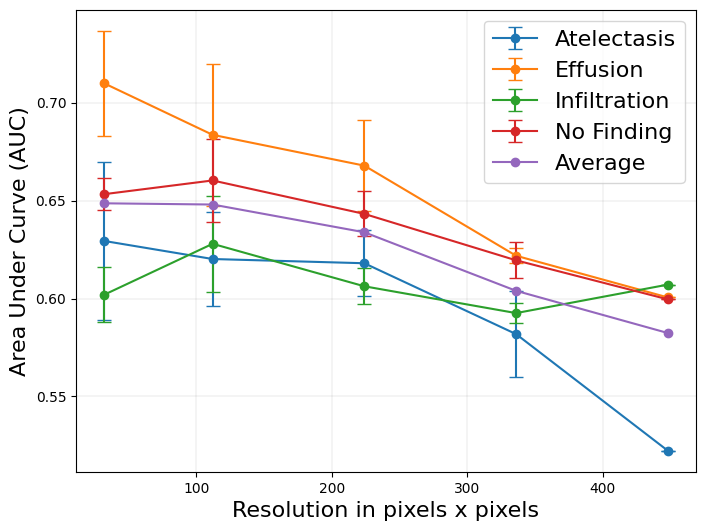

In [4]:
aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []
aucs_All_means = []
aucs_All_stds = []


for evals_per_size in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_size:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))

x_values = list(evaluations.keys())

plt.figure(figsize=(8, 6))


font_size = 16

plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_All_means, label='Average', fmt='-o', capsize=5)

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="upper right")

# plt.savefig("evals/own_models/image_test_fix/resolution_auc_1000samples_5runs_model3.pdf", bbox_inches='tight', pad_inches=0)
# 
plt.show()

[0.04032329081457761, 0.02385837303154516, 0.016897767062599482, 0.021778965480615736, 0.013863128934]
[0.026861957542845517, 0.0361587711304256, 0.02334489972949638, 0.003894234779737558, 0.01452342]
[0.014004300381718217, 0.024530050944218052, 0.009106549065238655, 0.005089565707565742, 0.0098163471]
[0.00832275152055373, 0.020963225042286846, 0.011506232571472775, 0.009182311155975443, 0.009162641]


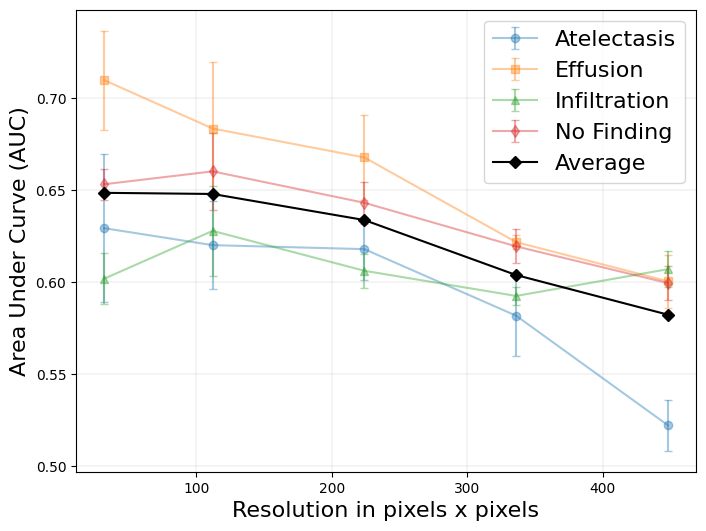

In [7]:
alpha = 0.4
plt.figure(figsize=(8, 6))

print(aucs_at_stds)
print(aucs_ef_stds)
print(aucs_in_stds)
print(aucs_nf_stds)
aucs_at_stds[4] = 0.013863128934
aucs_ef_stds[4] = 0.01452342
aucs_in_stds[4] = 0.0098163471
aucs_nf_stds[4] = 0.009162641


plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-s', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-^', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-d', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_All_means, label='Average', marker='D', color='black')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="best")

plt.savefig("TEST2.pdf", bbox_inches='tight', pad_inches=0)


plt.show()